# Sea Ice Indicators Update: Summary

##### 2021-05-07

This update presents a summary analysis of the sea ice indicators algorithm we have developed. It is indended to help guide initial manuscript development before implementing and iterating on creation of standalone publication-ready figures and other products for inclusion in a manuscript.

**Note** - since we're dealing with two different algorithms for calculating indicators, I will refer to "our" method as the "J&E" algorithm/indicators (Johnson & Eicken) and the NSIDC-0747 data/algorithm will be the "Steele" indicators (M. Steele is lead author on the data user guide). 

Here is the mapping of the J&H indicators to the Steele indicators: 

Freeze-up Start: Day of Advance  
Freeze-up End: Day of Closing  
Break-up Start: Day of Opening  
Break-up End: Day of Retreat  

## Previous update summaries

This section presents updated versions and iterations of graphical summaries that have already been shared in previous updates. 

The final tweak to the J&H algorithm was made after our last meeting, where we noticed "strange behavior" in the violin plots - for a few MAISE regions, such as the Yellow Sea, we saw many years where the mean Break-up End date occured before the Break-up Start date. The algorithm was not actually requiring that Break-up End come after Break-up Start, and it has been updated to do so. 

### J&H indicators definitions

#### Freeze-up Start

Valid date range: 9/1 - 1/31
  
1. Threshold is set to the minimum of 1) the sum of the mean + standard deviation of daily summer sea ice concentration (SIC), and 2) 15%
2. Freeze-up Start is defined as the first day the daily SIC exceeds the threshold
3. Undefined if:  
    a. daily SIC never exceeds this threshold  
    b. mean summer SIC is > 25%  
    c. subsequent Freeze-up End not defined  

#### Freeze-up End

Valid date range: 9/1 - 2/28

1. Threshold is set to the maximum of 1) mean SIC in winter minus 10%, and 2) 15% 
2. Threshold is set to the minimum of this threshold and 50%
3. Freeze-up end is defined as the first day after the Freeze-up Start date where the daily SIC exceeds the threshold for the following two weeks 
4. Undefined if:  
    a. Freeze-up Start not defined  
    b. daily SIC is above this threshold for every day of the search period

#### Break-up Start

Valid date range: 2/1 - 7/31

1. Threshold is set to the mean winter SIC minus 2 standard deviations of the winter SIC
2. Break-up Start is defined as the last day for which previous two weeks of the daily SIC exceeds this threshold
3. Undefined if:  
    a. subsequent Break-up end not defined  
    b. mean summer SIC is greater than 40%  

#### Break-up End

Valid date range: 2/1 - 9/29

1. Threshold is set to the minimum of 1) the sum of the mean + standard deviation of daily summer SIC, and 2) 50%
2. Break-up End is defined as the first day **after Break-up Start** where the daily SIC is less than the threshold for the following two weeks  
3. Undefined if:  
    a. Break-up Start not defined  
    b. daily SIC is less than the threshold for every day of the search period  


### Totals maps

Maps of counts of years where indicators are defined.

#### J&H indicators totals maps

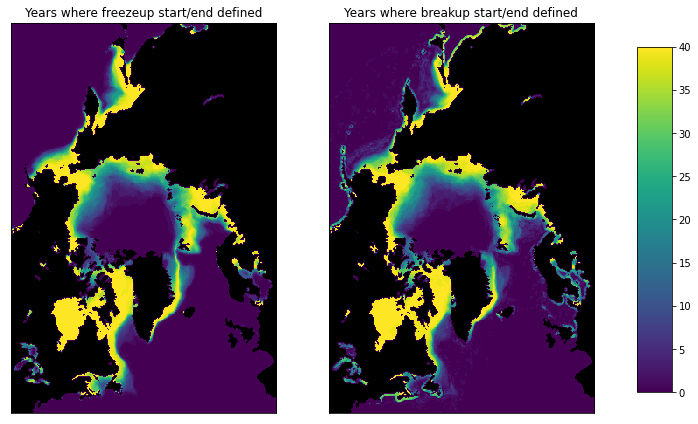

In [1]:
import copy
import os
import warnings
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import seaborn as sns
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from rasterstats import zonal_stats
from shapely.geometry import Polygon


def plot_counts(fubu_ds, landmask):
    """Count valid dates by indicator group (freezeup, breakup) 
    across all years and create a heat map
    """
    def prep_data(var):
        arr = fubu_ds[var].values.copy()
        valid = np.isnan(arr) == False
        counts = np.sum(valid, axis=0)
        plot_arr = np.ma.masked_where(landmask, counts)
        return plot_arr.astype("int32")
    
    varnames = ["freezeup_start", "breakup_start"] 
    plot_arrs = [prep_data(var) for var in varnames]
    
    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="black")
    fig, axs = plt.subplots(1, 2, figsize=(12,8))
    for arr,ax,var in zip(plot_arrs, axs, varnames):
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=0, vmax=40)
        i, m = var.split("_")
        ax.title.set_text(f"Years where {i} start/end defined")
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    return None


base_dir = Path(os.getenv("BASE_DIR"))
# computed fubu dates fp
fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")
# path to sample converted file to get landmask array
converted_fp = list(base_dir.joinpath("nsidc_0051/prepped").glob("*"))[0]

# load fubu dates netCDF
# set up meta data for saving GeoTIFFs
with rio.open(converted_fp) as src:
    # defined for global reference
    landmask = src.read(1) == 254
    # meta = src.meta

fubu_ds = xr.load_dataset(fubu_fp)

plot_counts(fubu_ds, landmask)

#### Steele indicators totals maps

*Freezeup (Day of Advance, Day of Closing)*

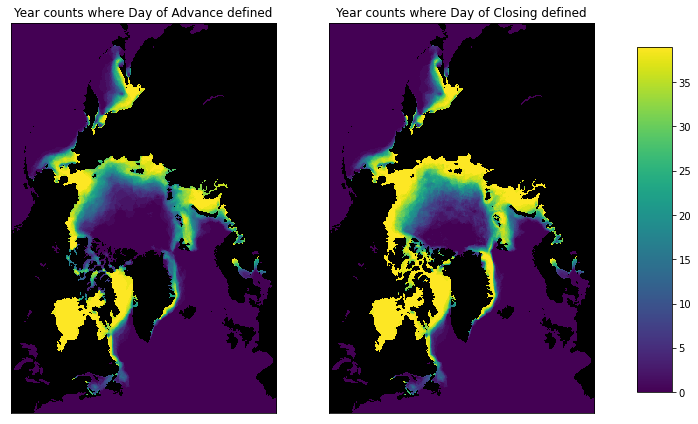

In [2]:
def plot_orac_counts(orac_ds, variables, titles):
    """Count valid dates by metric and create plot"""
    def prep_data(var):
        arr = orac_ds[var].values.copy()
        valid = arr > 0
        counts = np.sum(valid, axis=0)
        plot_arr = np.ma.masked_where(arr[0] == -4, counts)
        plot_arr[plot_arr == -5] = 0
        
        return plot_arr.astype("int32")
    
    plot_arrs = [prep_data(var) for var in variables]
    
    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="black")
    fig, axs = plt.subplots(1, 2, figsize=(12,8))
    for arr,ax,title in zip(plot_arrs, axs, titles):
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=0, vmax=39)
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return None

# NSIDC 0747 data
orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")
orac_ds = xr.load_dataset(orac_fp)
orac_vars = ("DOA", "DOC")
orac_titles = ("Year counts where Day of Advance defined", "Year counts where Day of Closing defined")
plot_orac_counts(orac_ds, orac_vars, orac_titles)

*Breakup (Day of Opening, Day of Retreat)*

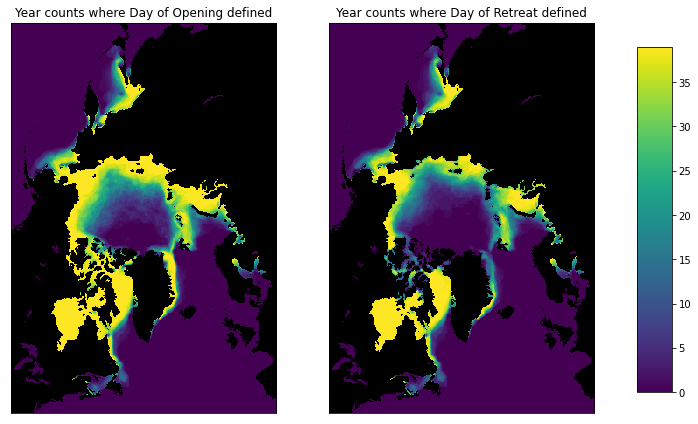

In [3]:
orac_vars = ("DOO", "DOR")
orac_titles = ("Year counts where Day of Opening defined", "Year counts where Day of Retreat defined")
plot_orac_counts(orac_ds, orac_vars, orac_titles)

#### Exclusive indicator start/end totals

The Steele algorithm does not require that start/end phases of freeze-up/break-up indicators be mutually dependent. Day of Closing can be defined for a pixel even if Day of Advance is not, and Day of Opening can be defined if Day of Retreat is not. The reverse is not true for either statement, so Day of Advance depends on Day of Closing, and Day of Retreat depends on Day of Opening. 

The following maps display the counts of years where this occurs for both indicator types:

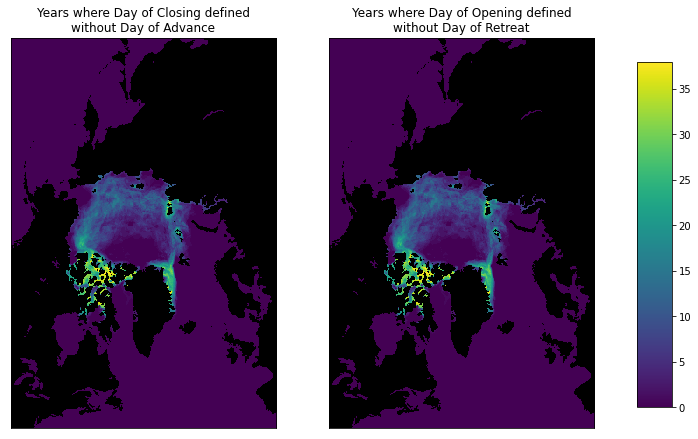

In [4]:
def prep_exclusive_end_counts(orac_ds, indicator1, indicator2):
    """Count instances where indicator1 is defined but not
    indicator2"""
    # create array for counting and set exclusive 
    # instances to 1 and sum to count
    exclusive_arr = np.zeros_like(orac_ds["DOC"].values)
    exclusive_arr[
        (orac_ds[indicator1].values != 0) & 
        (orac_ds[indicator2].values == 0)
    ] = 1
    
    # prep for plotting with masking
    plot_arr = np.ma.masked_where(
        orac_ds["DOA"].values[0] == -4, 
        exclusive_arr.sum(axis=0)
    )
    plot_arr[(plot_arr == -5) | (plot_arr == -1)] = 0
    
    return plot_arr

# keys in this dict are indicators that may be defined
# even the conjugate indicator is not 
indicator_lu = {"DOC": "DOA", "DOO": "DOR"}
plot_arrs = [prep_exclusive_end_counts(orac_ds, i, indicator_lu[i]) for i in ["DOC", "DOO"]]
    
# plot data
titles = [
    "Years where Day of Closing defined\nwithout Day of Advance",
    "Years where Day of Opening defined\nwithout Day of Retreat",
]
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="black")
fig, axs = plt.subplots(1, 2, figsize=(12,8))
for arr,ax,title in zip(plot_arrs, axs, titles):
    im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=0, vmax=38)
    ax.title.set_text(title)
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Although these appear very similar, they are slightly different, by 2 days at most in a small area NE of Greenland:

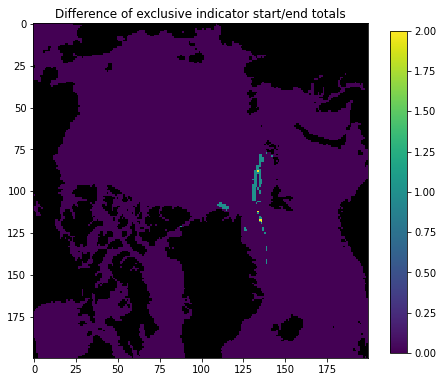

In [5]:
fig = plt.figure(figsize=(6,8))
im = plt.imshow((plot_arrs[1] - plot_arrs[0])[150:350, 50:250], interpolation="none", cmap=cmap)
plt.title("Difference of exclusive indicator start/end totals")
cbar_ax = fig.add_axes([0.95, 0.22, 0.04, 0.56])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Seems like an odd artifact of the Steele algorithm, not sure about its relevancy here but figured I'd include anyways. 

### Indicator date summaries

Graphical summaries of the indicator dates for both datasets for the years where indicators were actually defined. 

#### Definition rate violin plots by MASIE region

These figures show density plots (smoothed histograms) of the indicator "definition" rates - the percentage of grid cells within the region for which the given indicator was defined. Each line in the density plots corresponds to the definition rate for a particular year. 

*J&H indicators*

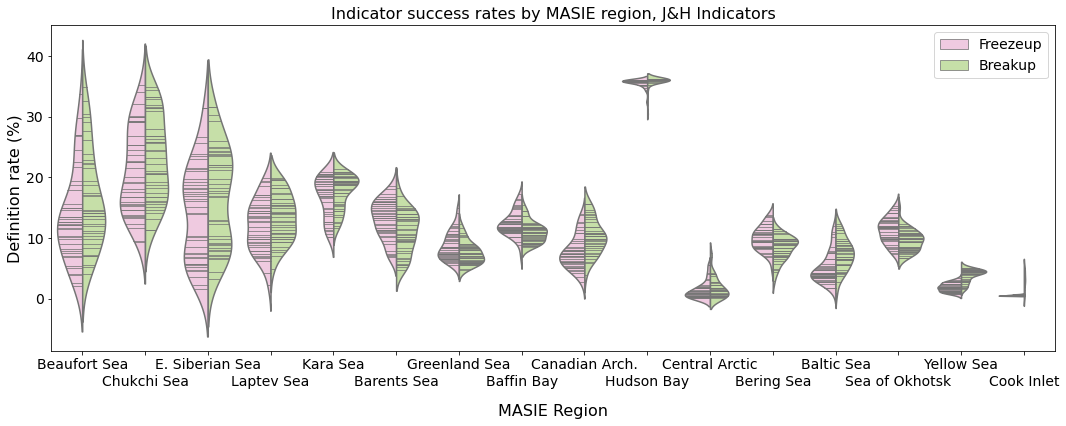

In [6]:
def get_polygon(row):
    """Create shapely polygon object from row of 
    alternating lat/lon coords
    """
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):
         
        if pd.isnull(value):
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)
            
    df = pd.DataFrame(df_di)
    
    return Polygon(list(zip(df.lon, df.lat)))


def make_plot_df(zs, stat, indicator=None, steele=False):
    """Make DataFrame for plotting"""
    # don't define indicator for freezeup/breakup comparison
    steele_indicator_lu = {
        "freezeup": ["Day of Advance", "Day of Closing"],
        "breakup": ["Day of Opening", "Day of Retreat"],
    }
    if indicator:
        if steele:
            variables = group_names = steele_indicator_lu[indicator]
        else:
            variables = [indicator + ind_type for ind_type in ["_start", "_end"]]
            group_names = ["Start", "End"]
    else:
        if steele:
            variables = group_names = ["Day of Closing", "Day of Opening"]
        else:
            variables = ["freezeup_start", "breakup_start"]
            group_names = ["Freezeup", "Breakup"]

    stats_df = pd.DataFrame({
        "region": np.tile(df["Name"].values, 2 * len(zs[variables[0]])),
        "indicator_type": np.repeat(group_names, len(zs[variables[0]]) * len(zs[variables[0]][0])),
        "value": [
            region_stats[stat] 
            for indicator in variables 
            for year_stats in zs[indicator] 
            for region_stats in year_stats]
    })

    return stats_df.replace({"region": {
        "Baffin Bay/Gulf of St. Lawrence": "Baffin Bay", 
        "Canadian Archipelago": "Canadian Arch.", 
        "East Siberian Sea": "E. Siberian Sea",
    }})


def plot_violin(stats_df, title, palette, loc="upper left", ylab="Day of year"):
    """Make violin plot from Prepped data frame"""
    plt.figure(figsize=(18, 6))
    ax = sns.violinplot(
        x="region", 
        y="value", 
        hue="indicator_type",
        data=stats_df, 
        palette=palette, 
        split=True,
        inner="stick",
    )
    
    # offset tick label placement to help display long region names
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)
    
    ax.xaxis.labelpad = 15
    plt.title(title, size=16)
    plt.xlabel("MASIE Region", size=16)
    plt.ylabel(ylab, size=16)
    plt.legend(loc=loc, prop={"size": 14})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()
    
    return None


masie_fp = base_dir.joinpath("ancillary/MASIE_regions_polygon_vertices.xls")

df = pd.read_excel(masie_fp, skiprows=1)

polys = df[["Region Number Identifier", "Name"]].copy()
for index, row in df.iterrows(): 
    polys.loc[index, "geometry"] = get_polygon(row)

polys = gpd.GeoDataFrame(polys).set_crs(epsg=4326).to_crs(epsg=3411)

with rio.open(f"netcdf:{fubu_fp}:breakup_end") as src:
    affine = src.meta["transform"]

def success_rate(x):
    # zonal_stats works on masked arrays, 
    # so need to set values in mask to nan
    x.data[x.mask == True] = np.nan
    x = x.data.flatten()
    sr = round(x[~np.isnan(x)].shape[0] / x.shape[0], 3) * 100
    if sr == 0:
        sr = None
    return sr

# compute stats for all variables
zs = {}
for variable in list(fubu_ds.variables)[:4]:
    zs[variable] = [
        zonal_stats(
            polys, 
            arr, 
            affine=affine,
            nodata=np.nan, 
            stats=["mean"],
            add_stats={"rate": success_rate}
        ) 
        for arr in fubu_ds[variable].values
    ]
    
plot_violin(
    make_plot_df(zs, "rate"), 
    "Indicator success rates by MASIE region, J&H Indicators", 
    "PiYG", 
    "upper right", 
    "Definition rate (%)"
)

*Steele indicators*

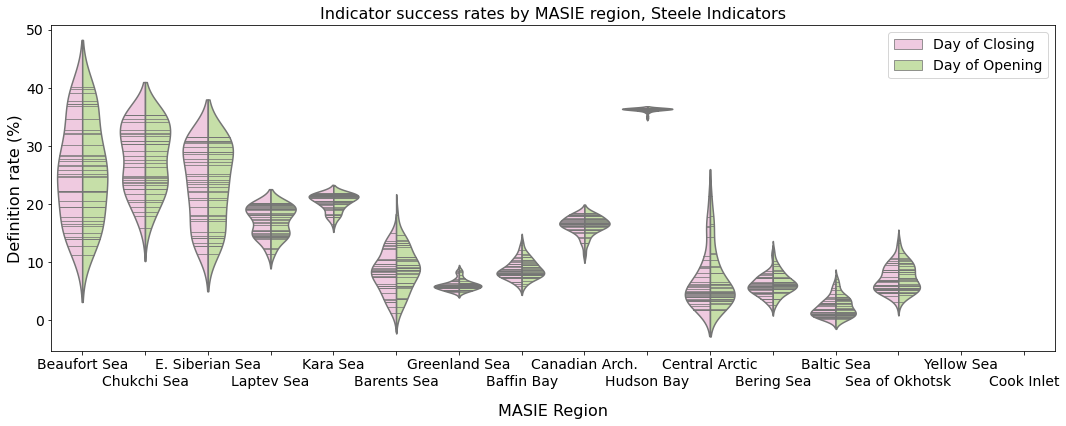

In [7]:
# pull out DOO and DOC and set all non-date values to np.nan
orac_arrs = np.array([
    orac_ds[indicator].values.copy() 
    for indicator in ["DOO", "DOC", "DOR", "DOA"]
])
orac_arrs[orac_arrs < 1] = np.nan
orac_zs = {}
for variable, var_arr in zip(["Day of Opening", "Day of Closing", "Day of Retreat", "Day of Advance"], orac_arrs):
    orac_zs[variable] = [
        zonal_stats(
            polys, 
            arr, 
            affine=affine, # same affine transform
            nodata=np.nan, 
            stats=["mean"],
            add_stats={"rate": success_rate}
        ) 
        for arr in var_arr
    ]
    
plot_violin(
    make_plot_df(orac_zs, "rate", steele=True), 
    "Indicator success rates by MASIE region, Steele Indicators", 
    "PiYG", 
    "upper right", 
    "Definition rate (%)"
)

#### Mean day of year violin plots by MASIE region

These plots show the density plots of mean day-of-year of indicators by MAISE region.

*Mean day of freezeup, J&H indicators*

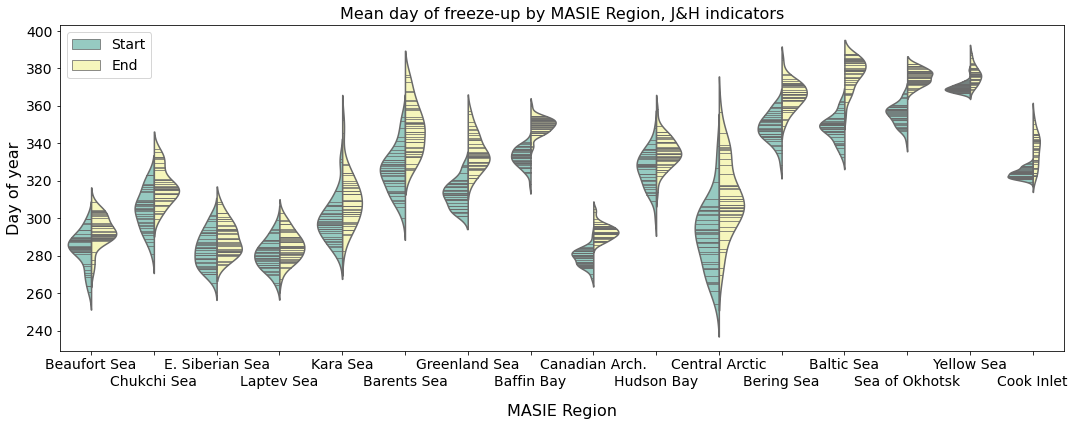

In [8]:
plot_violin(make_plot_df(zs, "mean", "freezeup"), "Mean day of freeze-up by MASIE Region, J&H indicators", "Set3")

*Mean day of freezeup, Steele indicators*

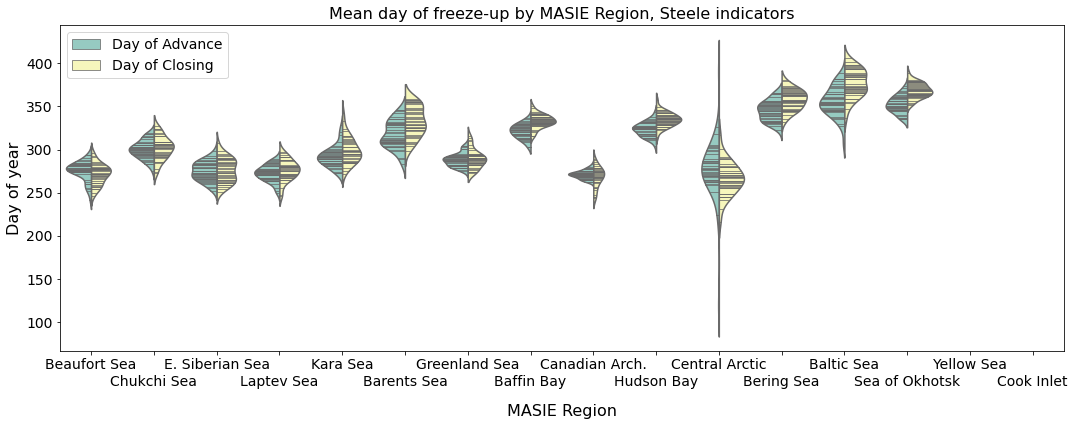

In [9]:
plot_violin(make_plot_df(orac_zs, "mean", "freezeup", steele=True), "Mean day of freeze-up by MASIE Region, Steele indicators", "Set3")

*Mean day of breakup J&H indicators*

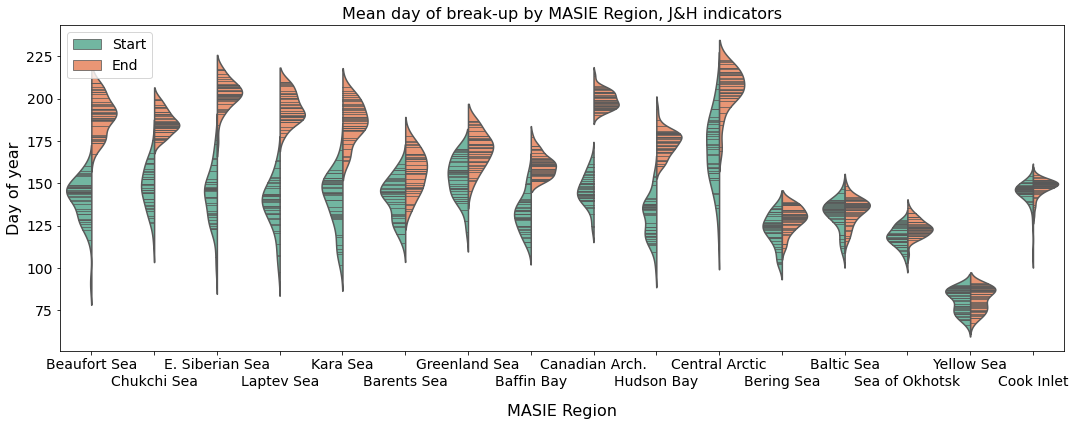

In [10]:
plot_violin(make_plot_df(zs, "mean", "breakup"), "Mean day of break-up by MASIE Region, J&H indicators", "Set2")

*Mean day of breakup, Steele indicators*

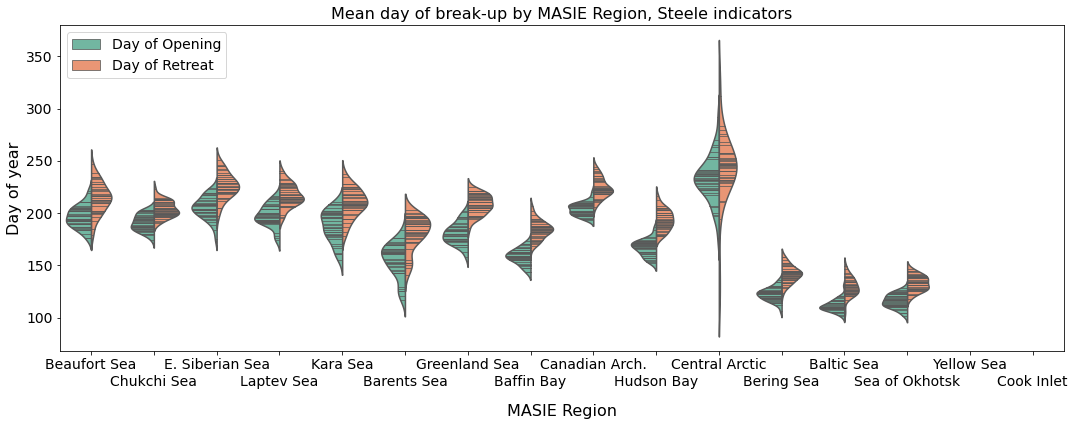

In [11]:
plot_violin(make_plot_df(orac_zs, "mean", "breakup", steele=True), "Mean day of break-up by MASIE Region, Steele indicators", "Set2")

#### Mean lagged date maps

These maps present the mean lag in days between the J&H indicators and the Steele indicators. 

The value displayed in each grid cell is calculated as the mean of the yearly differences between the J&H and Steele indicators ($JH - Steele$), so positive values indicate that the J&H indicator was defined before the Steele indicator on average.

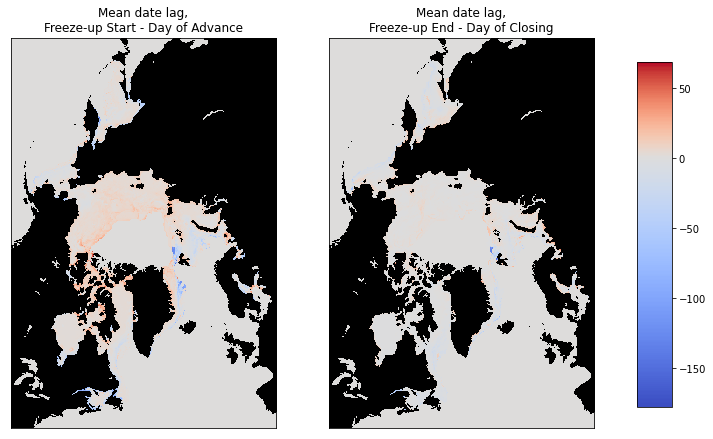

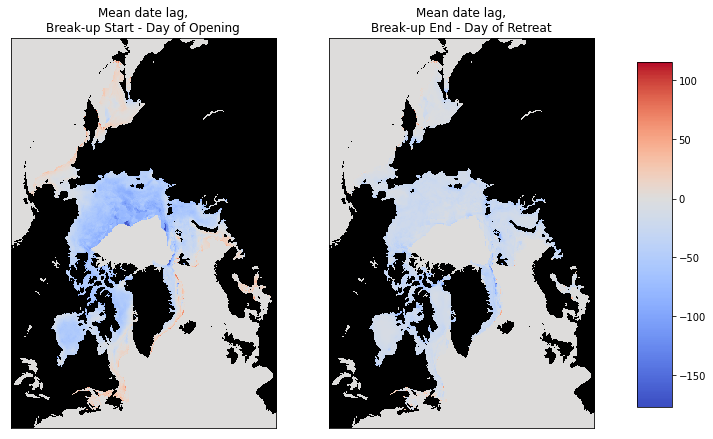

In [12]:
def plot_date_diff_comparison(ds1, ds2, vars1, vars2, titles):
    """Plot the mean difference in days between 
    fubu metrics for two data sets where both are defined
    """
    def prep_data(ds, variable):
        arr = ds[variable].values.copy()
        if variable in ["DOO", "DOC", "DOR", "DOA"]:
            arr[arr <= 0] = np.nan
        return arr
    
    orac_arrs = np.array([prep_data(ds1, var) for var in vars1])
    fubu_arrs = np.array([prep_data(ds2, var)[:39] for var in vars2])
    # compute difference as lag between fubu dates and oarc dates
    lag_arrs = fubu_arrs - orac_arrs
    # compute mean differences
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        mean_lag_arrs = np.array([np.nanmean(arr, axis=0) for arr in lag_arrs])
    # set all NaNs to zero and land mask to NaN
    mean_lag_arrs[np.isnan(mean_lag_arrs)] = 0
    mean_lag_arrs[ds1.DOO.values[:2] == -4] = np.nan
    
    cmap = copy.copy(plt.cm.get_cmap("coolwarm"))
    cmap.set_bad(color="black")
    # set diverging color map
    divnorm = colors.TwoSlopeNorm(
        vmin=np.nanmin(mean_lag_arrs), 
        vcenter=0, 
        vmax=np.nanmax(mean_lag_arrs)
    )
    fig, axs = plt.subplots(1, 2, figsize=(12,8))
    for arr,ax,title in zip(mean_lag_arrs, axs, titles):
        im = ax.imshow(
            arr, 
            interpolation="none", 
            cmap=cmap, 
            norm=divnorm
        )
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return None

fubu_vars = ["freezeup_start", "freezeup_end"]
orac_vars = ["DOA", "DOC"]
plot_date_diff_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    fubu_vars,
    ("Mean date lag,\nFreeze-up Start - Day of Advance", "Mean date lag,\nFreeze-up End - Day of Closing")
)

fubu_vars = ["breakup_start", "breakup_end"]
orac_vars = ["DOO", "DOR"]
plot_date_diff_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    fubu_vars,
    ("Mean date lag,\nBreak-up Start - Day of Opening", "Mean date lag,\nBreak-up End - Day of Retreat")
)

#### Mean date histograms

These histograms show the mean dates for each pair of complementary indicators. The J&H indicator is colored orange, and the complementary Steele indicator is colored blue. Transparency is enable to show where the charts overlap. 

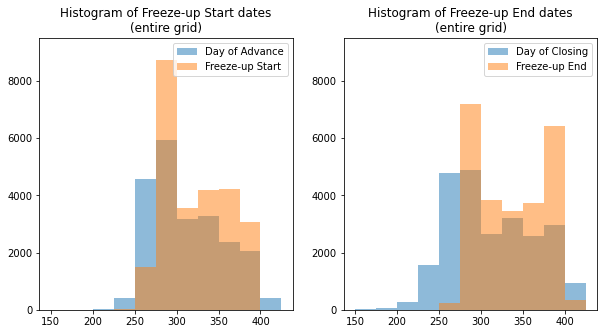

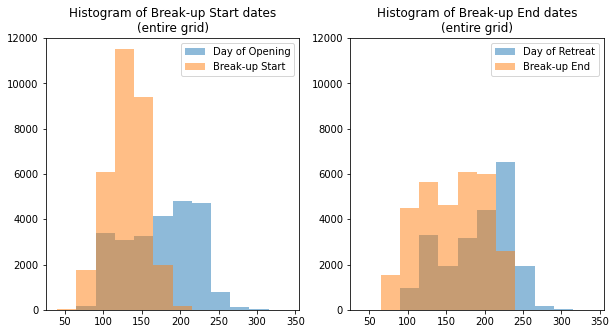

In [13]:
def plot_dates_hist_comparison(ds1, ds2, vars1, vars2, bins, ylim, titles):
    """Count valid dates by metric and create plot of histograms"""
    def prep_data(ds, variable):
        """Extract indicator and prepare for histogram"""
        # our algorithm
        arr = ds[variable].values.copy()
        if variable in ["DOO", "DOC", "DOR", "DOA"]:
            arr[arr <= 0] = np.nan

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            dates = np.nanmean(arr, axis=0)

        return dates[~np.isnan(dates)] 
    
    
    orac_args = [{"arr":prep_data(ds1, var), "label":varname} for var,varname in vars1.items()]
    fubu_args = [{"arr":prep_data(ds2, var), "label":varname} for var,varname in vars2.items()]
    plot_args = zip(orac_args, fubu_args)
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    histograms = []
    for args,ax,title in zip(plot_args, axs, titles):
        hist_list = [ax.hist(d["arr"], alpha=0.5, label=d["label"], bins=bins) for d in args]
        histograms.append(hist_list)
        ax.set_ylim(0, ylim)
        ax.title.set_text(title)
        ax.legend(loc='upper right')
    plt.legend()
    plt.show()
    
    return histograms

fubu_vars = {"freezeup_start": "Freeze-up Start", "freezeup_end": "Freeze-up End"}
orac_vars = {"DOA": "Day of Advance", "DOC": "Day of Closing"}
titles = [
    "Histogram of Freeze-up Start dates\n(entire grid)", 
    "Histogram of Freeze-up End dates\n(entire grid)",
]
histograms = plot_dates_hist_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    fubu_vars,
    np.arange(150, 450, 25),
    9500,
    titles,
)

fubu_vars = {"breakup_start": "Break-up Start", "breakup_end": "Break-up End"}
orac_vars = {"DOO": "Day of Opening", "DOR": "Day of Retreat"}
titles = [
    "Histogram of Break-up Start dates\n(entire grid)", 
    "Histogram of Break-up End dates\n(entire grid)",
]
histograms = plot_dates_hist_comparison(
    orac_ds,
    fubu_ds,
    orac_vars,
    fubu_vars,
    np.arange(40, 350, 25),
    12000,
    titles,
)

#### Mean date histograms by MASIE region

These histograms summarize the same variable as above, mean dates, but are broken out by MASIE region:

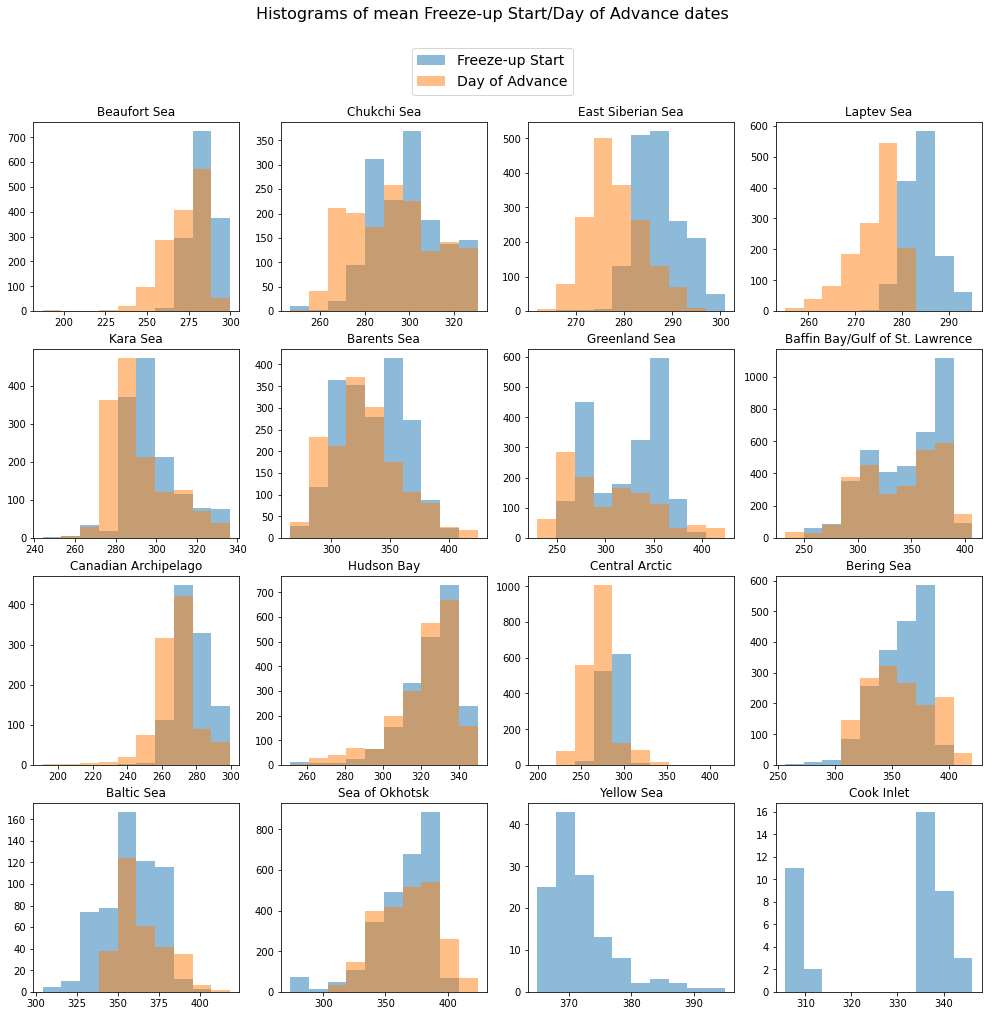

In [16]:
# def get_data(ma):
#     return ma.data[ma.mask == False]


def prep_data(ds, ds_varname):
    """Helper function to ensure orac_ds data
    is prepped for zonal_stats() with get_data().
    Does nothing do fubu_ds data except extract 
    from the dataset.
    """
    arr = ds[ds_varname].values.copy()
    arr[arr < 1] = np.nan
    return arr


def get_data(ma):
    ma.data[ma.mask == True] = np.nan
    return ma.data


def get_zonal_pixel_means(ds, names_lu):
    """Get the zonal data from an xarray dataset 
    and a names lookup structured as {<dataset varname>: <new varname>}
    and a data.frame of polygon geometries
    """
    zonal_pixel_means = {}
    for ds_varname, new_varname in zip(names_lu.keys(), names_lu.values()):
        # for each variable (indicator), 
        # use zonal_stats to get the data for a single year
        data_zs = [zonal_stats(
            polys,
            arr, 
            affine=affine, # same affine transform
            nodata=np.nan, 
            add_stats={"data": get_data}
        ) for arr in prep_data(ds, ds_varname)]
        
        # and unpack years to concatenate all data
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            
            zonal_pixel_means[new_varname] = {
                row[1]["Name"]: np.nanmean(
                    np.stack([year_stats[row[0]]["data"] for year_stats in data_zs]),
                    axis=0
                )
                for row in polys.iterrows()
            }
    
    return zonal_pixel_means


def remove_nan(arr):
    return arr[~np.isnan(arr)]


def plot_mean_dates_histograms_masie(fubu_varname):
    orac_varname_lu = {
        "Freeze-up Start": "Day of Advance",
        "Freeze-up End": "Day of Closing",
        "Break-up Start": "Day of Opening",
        "Break-up End": "Day of Retreat",
    }
    orac_varname = orac_varname_lu[fubu_varname]
    fig, axs = plt.subplots(4, 4, figsize=(17,16))
    axsi = [(i,j) for i,j in zip(np.repeat(np.arange(4), 4), np.tile(np.arange(4), 4))]
    for sea_name, axi in zip(fubu_zonal_pixel_means[fubu_varname], axsi):
        fubu_arr = remove_nan(fubu_zonal_pixel_means[fubu_varname][sea_name])
        orac_arr = remove_nan(orac_zonal_pixel_means[orac_varname][sea_name])
        counts, bins = np.histogram(np.concatenate([fubu_arr, orac_arr]))
        axs[axi].hist(fubu_arr, alpha=0.5, label=fubu_varname, bins=bins)
        axs[axi].hist(orac_arr, alpha=0.5, label=orac_varname, bins=bins)
        axs[axi].title.set_text(sea_name)

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.95), fontsize=14)

    fig.suptitle(f"Histograms of mean {fubu_varname}/{orac_varname} dates", fontsize=16)
    plt.show()
    
    return fig
    
    
fubu_names_lu = {
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
    "breakup_start": "Break-up Start", 
    "breakup_end": "Break-up End",
}
fubu_zonal_pixel_means = get_zonal_pixel_means(fubu_ds, fubu_names_lu)
    
orac_names_lu = {
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
    "DOO": "Day of Opening", 
    "DOR": "Day of Retreat",
}
orac_zonal_pixel_means = get_zonal_pixel_means(orac_ds, orac_names_lu)

fubu_varname = "Freeze-up Start"
fig = plot_mean_dates_histograms_masie("Freeze-up Start")

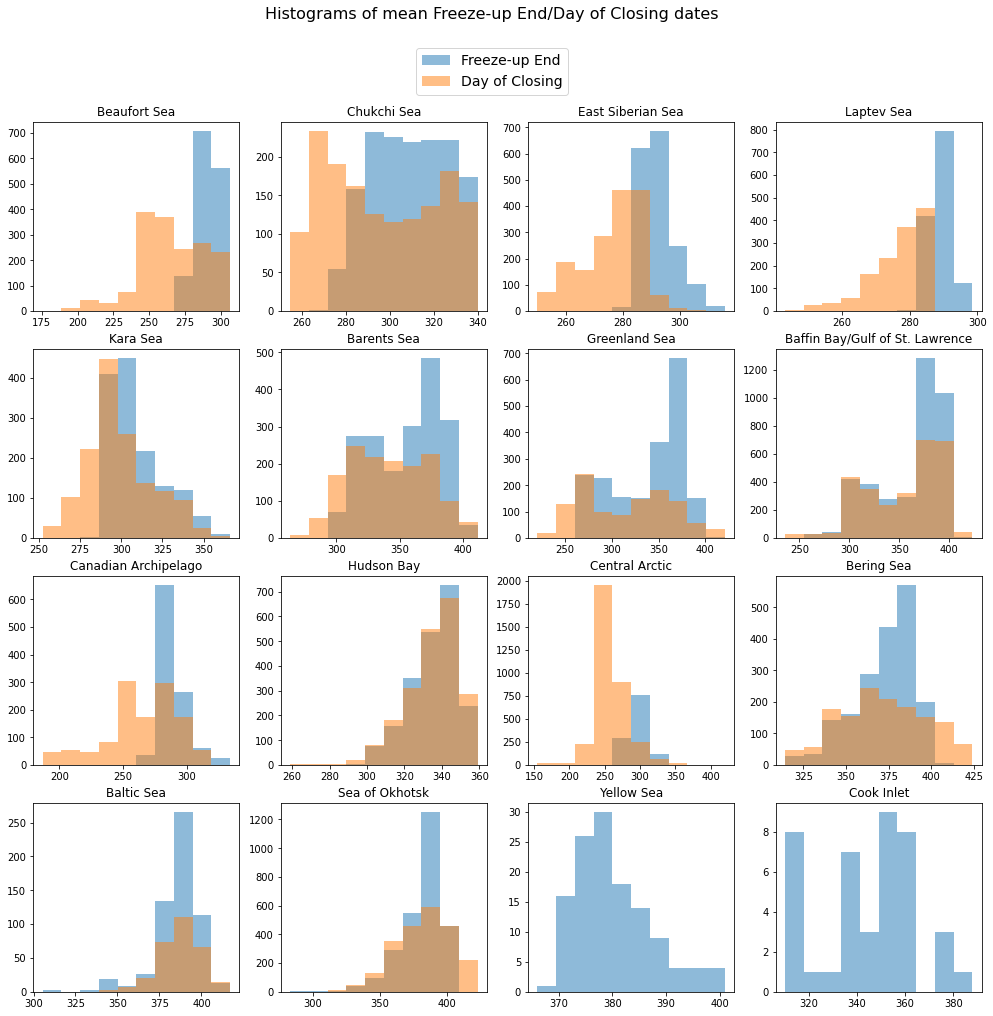

In [17]:
fig = plot_mean_dates_histograms_masie("Freeze-up End")

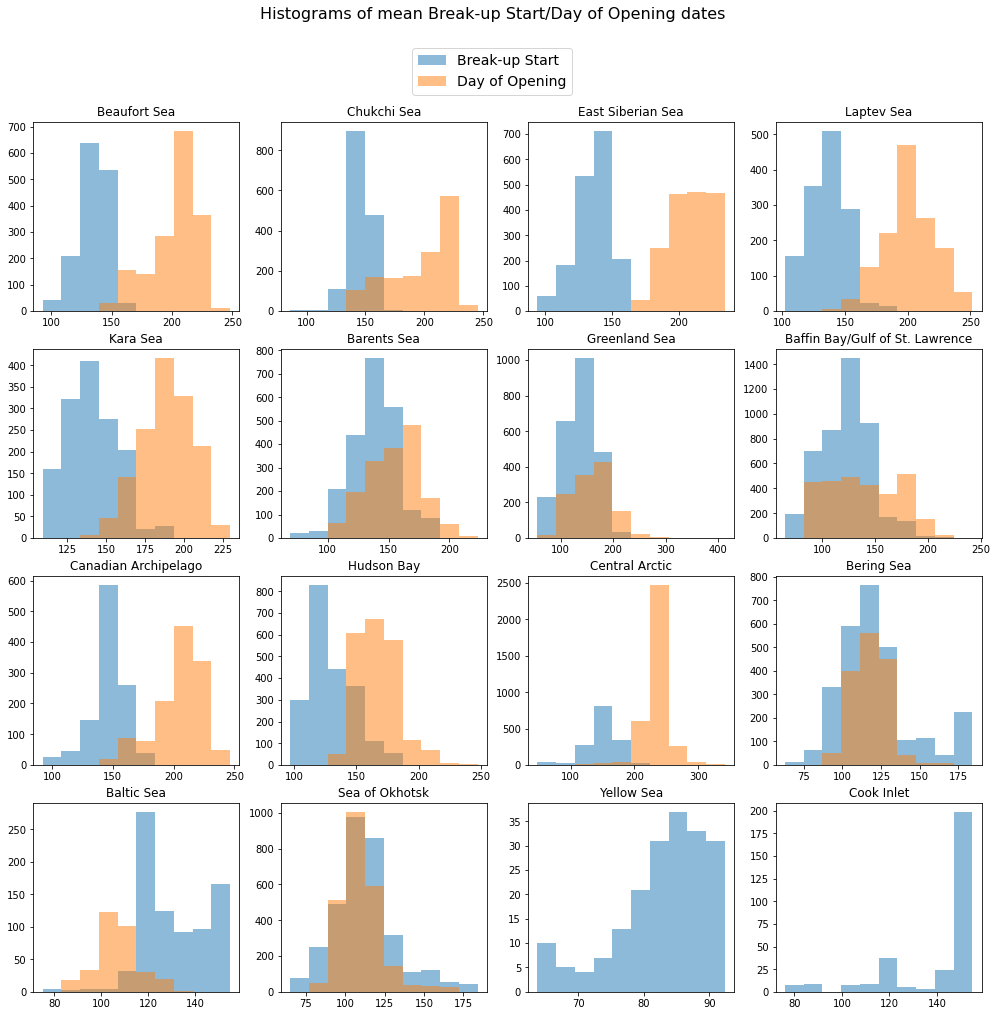

In [18]:
fig = plot_mean_dates_histograms_masie("Break-up Start")

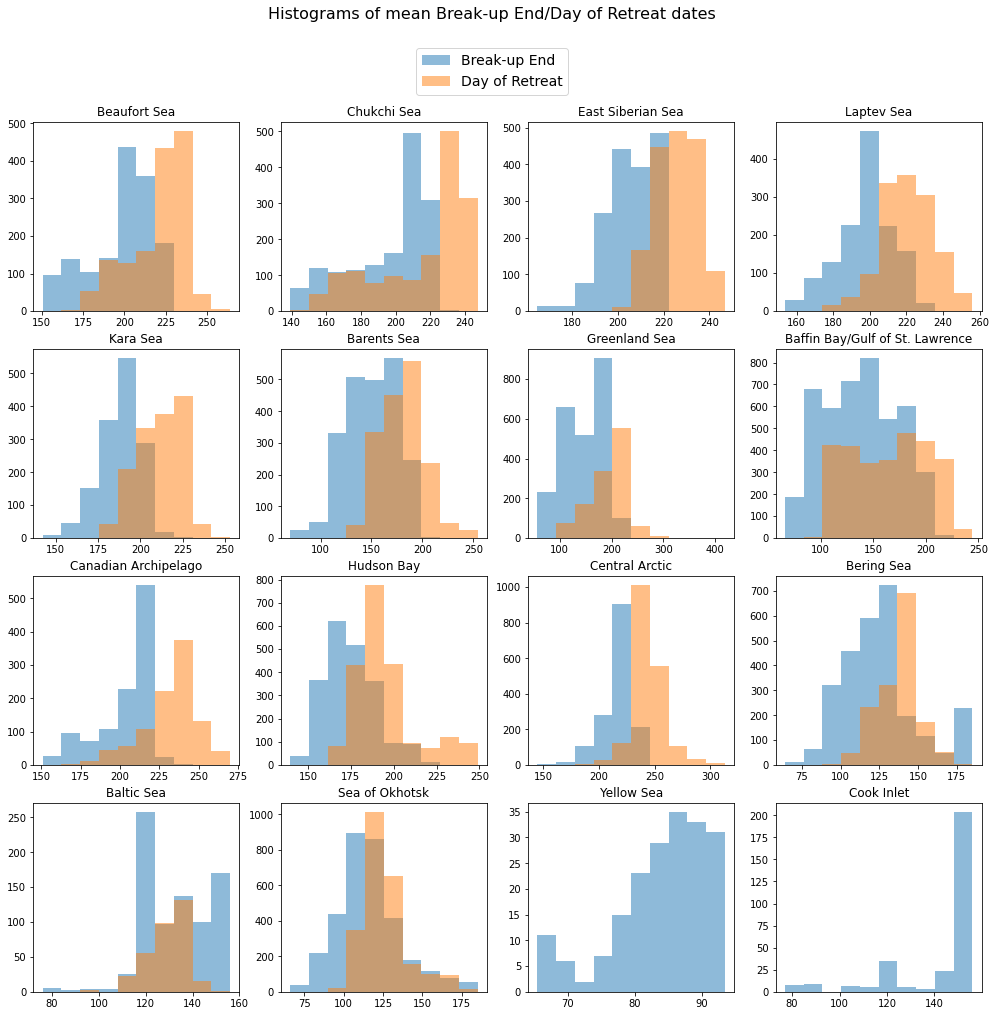

In [19]:
fig = plot_mean_dates_histograms_masie("Break-up End")

### Ice season length

#### Mean ice seaon length maps

These maps depict the mean length of the ice season in days (where defined), calculated as Break-up End minus Freeze-up Start. 

The plots on the right are simply modified to expose variation among grid cells with shorter historical ice seasons, such as those found at the southern extent of typical freeze-up. Grid cells with long historical ice seasons (means > 100) are set to 0.

*J&H indicators*

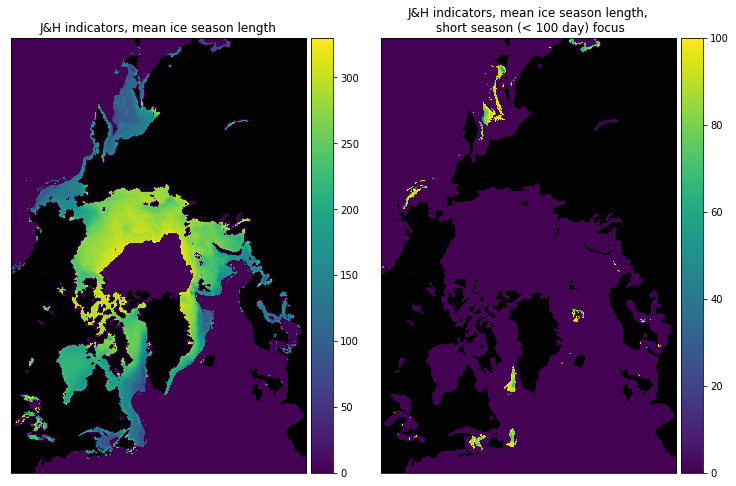

In [37]:
def plot_season_length(ds, titles, landmask=None):
    """Count valid dates by metric and plot"""
    if "freezeup_start" in list(ds.variables):
        season_lengths = (ds["breakup_end"].values + 365) - ds["freezeup_start"].values
    else:
        # calculate ice season length for NSIDC-0747 data as
        # day of retreat minus day of advance
        dor = ds["DOR"].values.copy()
        doa = ds["DOA"].values.copy()
        invalid_mask = dor < 0
        undefined_mask = dor == 0
        dor += 365
        dor[(invalid_mask | undefined_mask)] = np.nan
        doa[(invalid_mask | undefined_mask)] = np.nan
        season_lengths = dor - doa
        landmask = ds["DOA"].values[0] == -4
        pole_sea_mask = (ds["DOA"].values == -5) | (ds["DOA"].values == -1)
        season_lengths[(pole_sea_mask | undefined_mask)] = 0
        
    length_arrs = np.array([season_lengths, season_lengths])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        plot_arrs = np.nanmean(length_arrs, 1)
        
    filter_max = 100
    plot_arrs[1][plot_arrs[1] >= filter_max] = 0
    plot_arrs[np.isnan(plot_arrs)] = 0
    plot_arrs = [np.ma.masked_where(landmask, arr) for arr in plot_arrs]
        
    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="black")
    fig, axs = plt.subplots(1, 2, figsize=(14,8))
    fig.subplots_adjust(wspace=-0.1)
    for arr,ax,title,vmax in zip(plot_arrs, axs, titles, [330, 100]):
        arr.data[arr.mask] = np.nan
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=0, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=False)
        fig.colorbar(im, ax=cax)
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
    return plot_arrs

titles = ["J&H indicators, mean ice season length", "J&H indicators, mean ice season length,\n short season (< 100 day) focus"]
fubu_isl_arrs = plot_season_length(fubu_ds, titles, landmask)

Note: addressing a point raised in our previous discussion, the ice season lengths seeming too short: I had the calculation incorrect. I was taking Break-up End minus Break-up Start, instead of Freeze-up Start! Sorry about that, this has been corrected for the maps above. 


Note: cells with values of 0 (dark violet) indicate either no freeze-ups ever occurred, or no break-ups occurred, or both. 

*Steele indicators* 

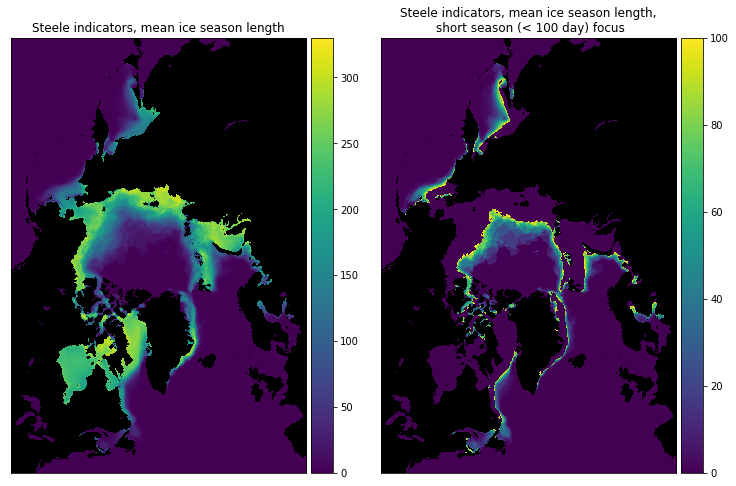

In [38]:
titles = ["Steele indicators, mean ice season length", "Steele indicators, mean ice season length,\n short season (< 100 day) focus"]
temp = plot_season_length(orac_ds, titles)

## Trend analyses (preliminary)

This section provides a short analysis of sea ice trends over time at Utqiaġvik, AK. The remaining trend analyses will come in the following update. 

The grid cell we will use for this instance is the one conatining Utqiaġvik:

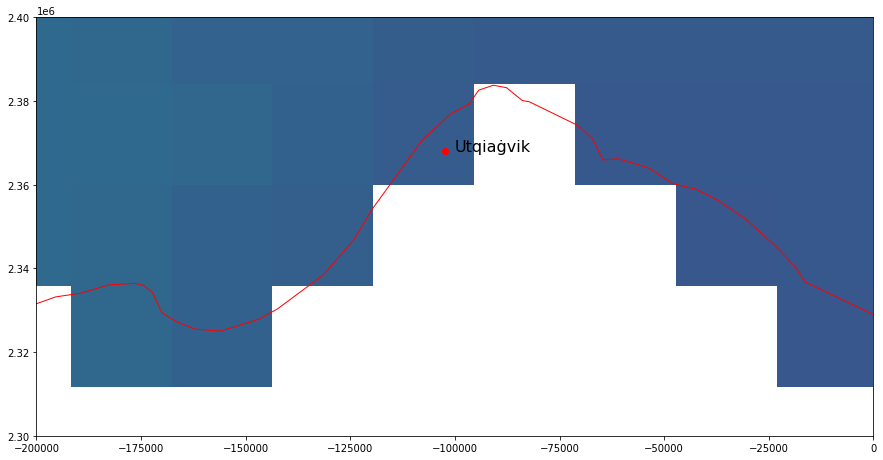

In [146]:
import rioxarray

fubu_3411 = fubu_ds.rio.write_crs("EPSG:3411")
fubu_3338 = fubu_3411.rio.set_spatial_dims("xc", "yc").rio.reproject("EPSG:3338")
fubu_3338["freezeup_start"].rio.to_raster("/atlas_scratch/kmredilla/seaice_noaa_indicators/freezeup_start.tif")

import geopandas as gpd

data = gpd.read_file("/atlas_scratch/kmredilla/seaice_noaa_indicators/shapefiles/Boroughs.shp")
data = data.to_crs(epsg=3338)

from rasterio import plot

with rio.open("/atlas_scratch/kmredilla/seaice_noaa_indicators/freezeup_start.tif") as src:
    fig, ax = plt.subplots(figsize=(15, 15))
    plot.show(src, ax=ax)
    data.set_index("NAME").loc[["North Slope Borough"]].plot(ax=ax, facecolor='none', edgecolor='r')
    ax.set_xlim([-200000, 0])
    ax.set_ylim([2300000, 2400000])
    ax.scatter(-102347.938497, 2368027.86485, color="red")
    ax.text(-100000, 2368030, "Utqiaġvik", size=16)

### Trend visualizations for J&H Indicators

#### Freeze-up Start

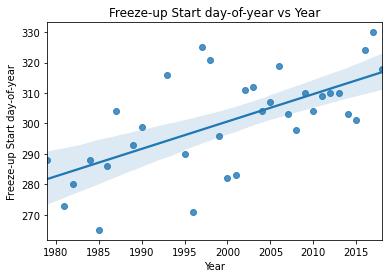

In [162]:
import seaborn as sns

utqiagvik_fubu = fubu_3338.sel(x=-102347.938497, y=2368027.86485, method="nearest")

var = "freezeup_start"
ylab = "Freeze-up Start day-of-year"
title = f"{ylab} vs Year"
ax = sns.regplot(x=utqiagvik_fubu["year"].values, y=utqiagvik_fubu[var].values)
ax.set(xlabel="Year", ylabel=ylab)
plt.title(title)
plt.show()

#### Freeze-up End

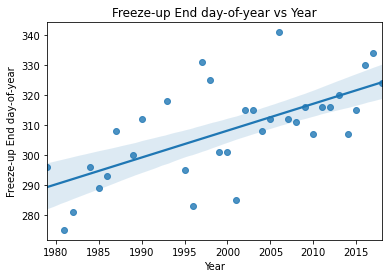

In [163]:
var = "freezeup_end"
ylab = "Freeze-up End day-of-year"
title = f"{ylab} vs Year"
ax = sns.regplot(x=utqiagvik_fubu["year"].values, y=utqiagvik_fubu[var].values)
ax.set(xlabel="Year", ylabel=ylab)
plt.title(title)
plt.show()

#### Break-up Start

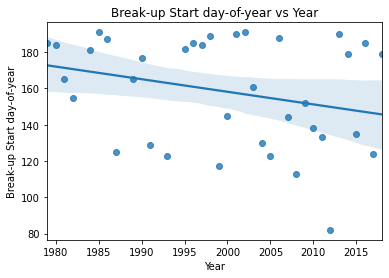

In [164]:
var = "breakup_start"
ylab = "Break-up Start day-of-year"
title = f"{ylab} vs Year"
ax = sns.regplot(x=utqiagvik_fubu["year"].values, y=utqiagvik_fubu[var].values)
ax.set(xlabel="Year", ylabel=ylab)
plt.title(title)
plt.show()

#### Break-up End

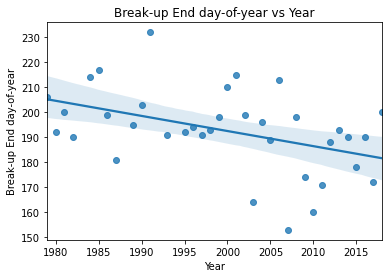

In [165]:
var = "breakup_end"
ylab = "Break-up End day-of-year"
title = f"{ylab} vs Year"
ax = sns.regplot(x=utqiagvik_fubu["year"].values, y=utqiagvik_fubu[var].values)
ax.set(xlabel="Year", ylabel=ylab)
plt.title(title)
plt.show()